### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2B.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[   0    9]
 [   0  120]
 [   0 1244]
 [   0   25]
 [   0   63]
 [   0   11]
 [   0   70]
 [   0   68]
 [   0    9]
 [   0  459]
 [   0   12]
 [   0    6]
 [   0   10]
 [   0   10]
 [   0  227]
 [   0   67]
 [   0   81]
 [   0    2]
 [   0   47]
 [   0    5]
 [   0   32]
 [   0   75]
 [   0  461]
 [   0  211]
 [   0   60]
 [   0   17]
 [   0   79]
 [   0   67]
 [   0   21]
 [   0    8]
 [   0  120]
 [   0   61]
 [   0    1]
 [   0   61]
 [   0   58]
 [   0    2]
 [   0   62]
 [   0   10]
 [   0   28]
 [   0  148]
 [   0   64]
 [   0   48]
 [   0   15]
 [   0   57]
 [   0   60]
 [   0   60]
 [   0   79]
 [   0   63]
 [   0   71]
 [   0   15]
 [   0   26]
 [   0  145]
 [   0   17]
 [   0   62]
 [   0   56]
 [   0   63]
 [   0   24]
 [   0   42]
 [   0   68]
 [   0    9]
 [   0   38]
 [   0  123]
 [   0   34]
 [   0   86]
 [   0   20]
 [   0   21]
 [   0   47]
 [   0   40]
 [   0   18]
 [   0   42]
 [   0   38]
 [   0   33]
 [   0   27]
 [   0   28]
 [   0   21]
 [   0   22]
 [   0    6]

 ## Extract Droplet Centroids

[[879 685]
 [532 682]
 [ 65 683]
 [589 675]
 [755 678]
 [459 679]
 [882 673]
 [263 677]
 [819 665]
 [561 659]
 [867 647]
 [752 638]
 [834 642]
 [ 66 640]
 [ 47 638]
 [766 634]
 [468 630]
 [ 89 629]
 [754 625]
 [ 95 622]
 [744 621]
 [782 623]
 [164 653]
 [452 614]
 [ 94 614]
 [661 614]
 [788 610]
 [780 605]
 [452 604]
 [786 598]
 [364 637]
 [262 615]
 [589 597]
 [521 578]
 [746 584]
 [ 95 580]
 [ 78 552]
 [ 32 589]
 [592 545]
 [389 555]
 [491 553]
 [737 535]
 [587 533]
 [604 533]
 [763 530]
 [182 559]
 [429 520]
 [667 550]
 [ 17 498]
 [388 502]
 [284 523]
 [588 494]
 [776 477]
 [725 493]
 [111 495]
 [ 18 482]
 [815 449]
 [724 433]
 [807 429]
 [212 459]
 [923 418]
 [471 440]
 [152 414]
 [ 60 414]
 [603 416]
 [336 421]
 [844 386]
 [529 374]
 [567 357]
 [893 355]
 [225 375]
 [744 356]
 [686 398]
 [580 346]
 [811 341]
 [838 337]
 [795 336]
 [341 335]
 [293 339]
 [786 322]
 [129 344]
 [635 332]
 [356 310]
 [788 303]
 [925 305]
 [721 306]
 [272 301]
 [703 303]
 [358 296]
 [908 305]
 [425 334]

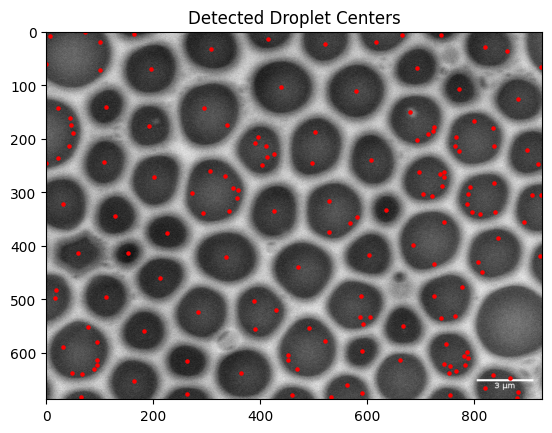

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample10A.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply a Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (3, 3), 0)

# Use Otsu's thresholding to segment pores
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological opening to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Detect connected components
num_labels, labels = cv2.connectedComponents(cleaned)

# Compute centroids
centers = []
for label_id in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label_id).astype(np.uint8)
    M = cv2.moments(mask, binaryImage=True)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append((cX, cY))

# Convert grayscale to BGR for drawing
marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
print(centroids)
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()



[[879 685]
 [532 682]
 [ 65 683]
 [589 675]
 [755 678]
 [459 679]
 [882 673]
 [263 677]
 [819 665]
 [561 659]
 [867 647]
 [752 638]
 [834 642]
 [ 66 640]
 [ 47 638]
 [766 634]
 [468 630]
 [ 89 629]
 [754 625]
 [ 95 622]
 [744 621]
 [782 623]
 [164 653]
 [452 614]
 [ 94 614]
 [661 614]
 [788 610]
 [780 605]
 [452 604]
 [786 598]
 [364 637]
 [262 615]
 [589 597]
 [521 578]
 [746 584]
 [ 95 580]
 [ 78 552]
 [ 32 589]
 [592 545]
 [389 555]
 [491 553]
 [737 535]
 [587 533]
 [604 533]
 [763 530]
 [182 559]
 [429 520]
 [667 550]
 [ 17 498]
 [388 502]
 [284 523]
 [588 494]
 [776 477]
 [725 493]
 [111 495]
 [ 18 482]
 [815 449]
 [724 433]
 [807 429]
 [212 459]
 [923 418]
 [471 440]
 [152 414]
 [ 60 414]
 [603 416]
 [336 421]
 [844 386]
 [529 374]
 [567 357]
 [893 355]
 [225 375]
 [744 356]
 [686 398]
 [580 346]
 [811 341]
 [838 337]
 [795 336]
 [341 335]
 [293 339]
 [786 322]
 [129 344]
 [635 332]
 [356 310]
 [788 303]
 [925 305]
 [721 306]
 [272 301]
 [703 303]
 [358 296]
 [908 305]
 [425 334]

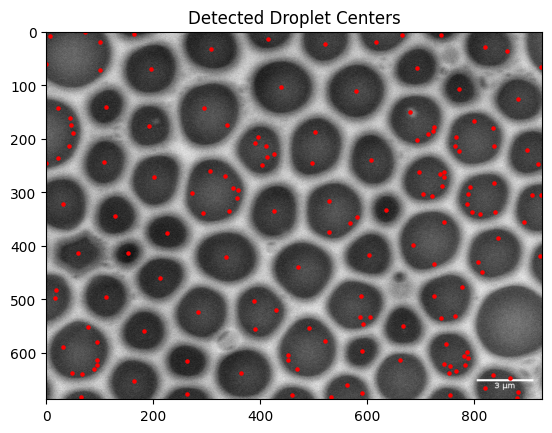

In [8]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample10A.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Contrast Enhancement (Histogram Equalization)
equalized_image = cv2.equalizeHist(image)

# Step 2: Apply Manual Thresholding (with dynamic range)
# Experiment with threshold values based on your image contrast
_, thresh = cv2.threshold(equalized_image, 100, 255, cv2.THRESH_BINARY_INV)

# Step 3: Apply Morphological Operations (Opening followed by Closing)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # More elliptical kernel for smoother operation
opened_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

# Step 4: Find Contours instead of using Blob Detector
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Identify Droplet Centroids using Contour Moments
centroids = []
for contour in contours:
    # Calculate the centroid of each contour using moments
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Prevent division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append([cx, cy])
# centroids.append([267,98])
# Convert centroids to a numpy array for easier plotting
centroids = np.array(centroids)

print(centroids)
# centroids = np.all(np.isin(centroids,rows_to_remove),axis=1)
# centroids = centroids[~centroids]
# print(centroids.shape)
# Plot Results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()


[[ 69 679]
 [751 677]
 [461 676]
 [264 676]
 [849 670]
 [  3 671]
 [562 667]
 [842 640]
 [262 616]
 [589 598]
 [182 559]
 [667 550]
 [ 19 496]
 [660 459]
 [918 433]
 [152 415]
 [ 62 414]
 [226 375]
 [130 344]
 [636 332]
 [905 330]
 [898 226]
 [193 176]
 [112 141]
 [814  97]
 [774 105]
 [692  66]
 [913  30]
 [738   7]
 [628  16]
 [520  25]
 [415  15]
 [165   5]]


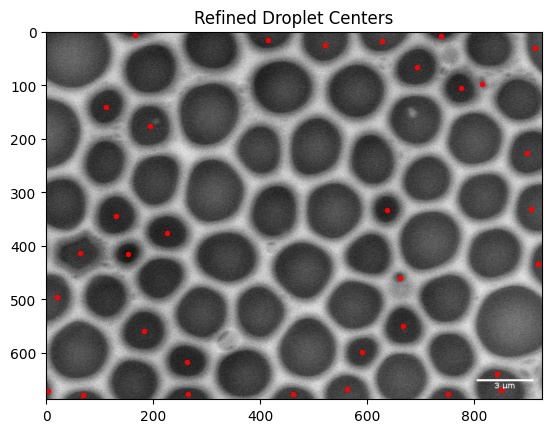

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample10A.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Apply Otsu’s Thresholding for better segmentation
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Morphological Operations to refine segmentation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 4: Find Contours and Filter by Area
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
min_area = 100  # Adjust to remove small noise
max_area = 5000  # Adjust to exclude large non-droplet objects

for contour in contours:
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        # Use Convex Hull to refine the droplet shape
        hull = cv2.convexHull(contour)
        M = cv2.moments(hull)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append([cx, cy])

# Convert to numpy array
centroids = np.array(centroids)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Refined Droplet Centers')
plt.show()


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample10.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Use adaptive thresholding to segment pores
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours of the pores
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Compute the centers of the detected pores
centers = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centers.append((cx, cy))
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


[ WARN:0@287.085] global loadsave.cpp:268 findDecoder imread_('sample10.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/smooth.dispatch.cpp:618: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


## Perform Voronoi Tessellation

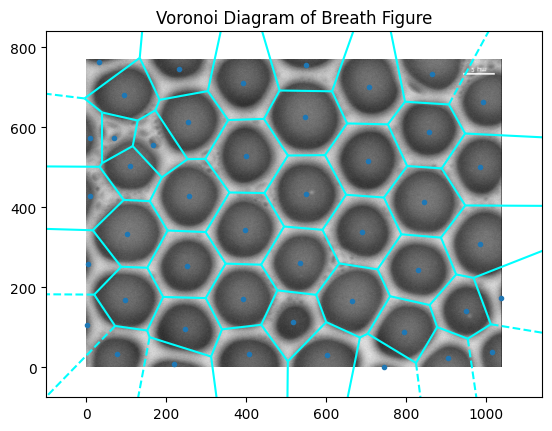

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

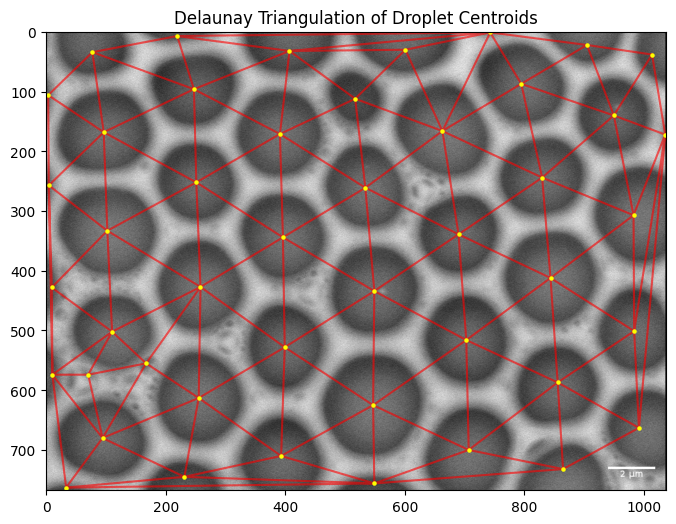

In [6]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.61


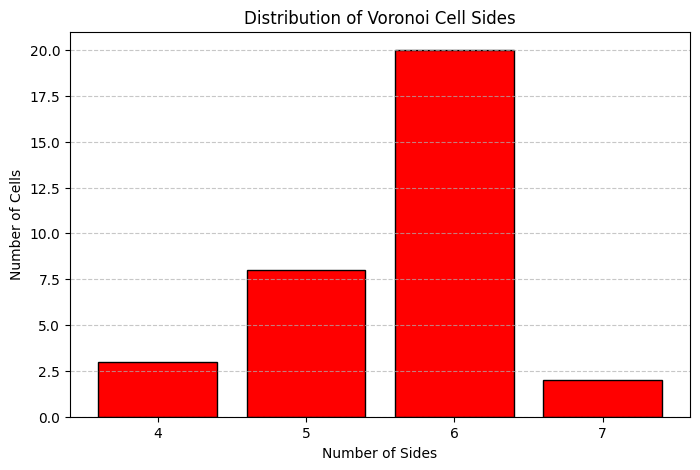

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

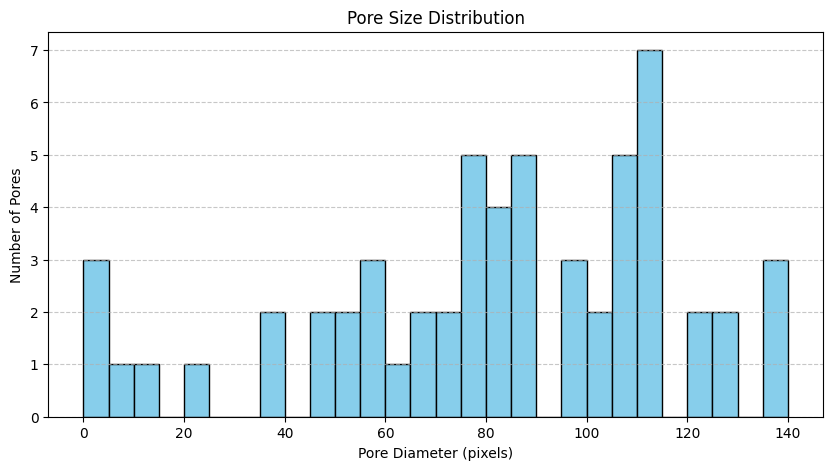

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()